# Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./deepracer-reinvent-track.jpg)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on SageMaker and a simulation job on RoboMaker.

In [1]:
from src.core.DeepRacerEngine import DeepRacerEngine

### Scenario 1: Single Model Run and Evaluation

For this scenario, we are going to run a single model, over a chosen track

### Set Up Parameters
There are two set of parameters we can configure:
 - The simulation parameters
 - The model hyperparameters

#### View Default Simulation Parameters

In [2]:
!pygmentize common/constant.py

# Estimator Pamrs
entry_point = "training_worker.py"
source_dir = 'src'

#Training Params
default_instance_type = "ml.c4.2xlarge" #For GPU use 'ml.p3.2xlarge'
default_instance_pool = 1
default_job_duration = 3600
default_hyperparam_preset = 'src/markov/presets/preset_hyperparams.json'
tmp_hyperparam_preset = 'src/markov/presets/preset_hyperparams_tmp.py'

#Track Details:
default_track_name = 'reinvent_base'
track_name = ['reinvent_base', 'reinvent_carpet', 'reinvent_concrete', 'reinvent_wood', 'AWS_track',
              'Bowtie_track', 'Oval_track',  'Straight_track']

# Evaluation Trials
evaluation_trials = 5

## Policy and Model Meta Data
envir_file_local = 'src/markov/environments/deepracer_racetrack_env.py'
reward_file_local = 'src/markov/rewards/complex_reward.py'
model_meta_file_local = 'src/markov/actions/model_metadata_10_state.json'
presets_file_local = 'src/markov/presets/preset_attention_layer.py'


#### View Default Hypterparameters

In [3]:
!pygmentize src/markov/presets/preset_hyperparams.json

{
    "learning_rate": 0.0003,
    "batch_size" : 64,
    "optimizer_epsilon" : 0.00001,
    "adam_optimizer_beta2" : 0.999,
    "clip_likelihood_ratio_using_epsilon" : 0.2,
    "beta_entropy" : 0.01,
    "gae_lambda" : 0.95,
    "discount" : 0.999,
    "optimization_epochs" : 10
}


#### Set Parameters

In [4]:
#here we can set the params we want to use for our model runs
params = {
    'job_name': 'dr-test-lll',
    'track_name':'reinvent_base',
    'job_duration': 3600,
    'batch_size':128,
    'evaluation_trials':5
}

#### Instantiate the DeepRacerEngine class, and provide the params

In [5]:
deepRacer = DeepRacerEngine(params)

***Deep Racer Engine Backend***


#### Start Simulation Training 

In [6]:
deepRacer.start_training_testing_process()

********************************
PERFORMING ALL DOCKER, VPC, AND ROUTING TABLE WORK....
Using s3 bucket sagemaker-us-east-1-170991494985
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-170991494985/dr-test-lll-sagemaker-191223-082408
Using Sagemaker IAM role arn: 
arn:aws:iam::170991494985:role/service-role/AmazonSageMaker-ExecutionRole-20191119T175598
Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Sagemaker docker id : eeb8e5d6dad7
docker run -d -t eeb8e5d6dad7
docker exec -d e98985949ad904c237f4521b6a26b348aef6ee50c38e11c9db581776d6b3e555 rm -rf /opt/amazon/markov
docker cp ./src/markov e98985949ad904c237f4521b6a26b348aef6ee50c38e11c9db581776d6b3e555:/opt/amazon/markov
============ Copied Markov scripts to sagemaker docker ============ 
 
docker ps -l|sed -n 2,2p
docker commit e98985949ad9 sagemaker-docker-cpu
============ Commited all the changes to docker ============ 
 
Using the D

#### Start Evaluation Proces


In [ ]:
deepRacer.start_model_evaluation()

Create local folder tmp/dr-test-lll-2019-12-23-08-24-11-551
Waiting for s3://sagemaker-us-east-1-170991494985/dr-test-lll-sagemaker-191223-082408/training_metrics.json...


TypeError: 'AxesSubplot' object does not support indexing

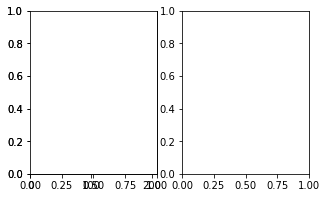

In [8]:
deepRacer.plot_training_output()

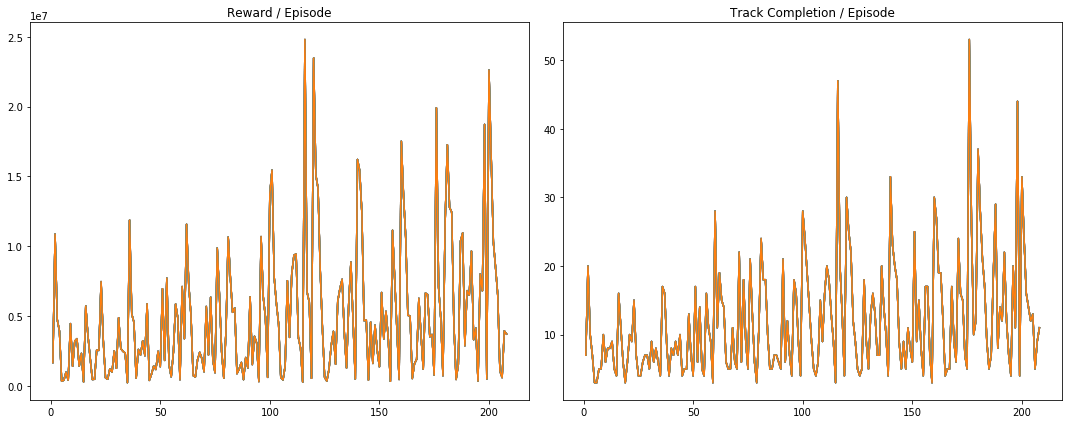

In [ ]:
## import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output
from misc import get_execution_role, wait_for_s3_object
import numpy as np

def plot_training_output(self):
        self.tmp_root = 'tmp/'
        os.system("mkdir {}".format(self.tmp_root))
        self.tmp_dir = "tmp/{}".format(self.job_name)
        os.system("mkdir {}".format(self.tmp_dir))
        print("Create local folder {}".format(self.tmp_dir))

        self.training_metrics_file = "training_metrics.json"
        self.training_metrics_path = "{}/{}".format(self.s3_prefix, self.training_metrics_file)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
#         ax = fig.add_subplot(1, 2, 1)

        x_axis = 'episode'
        y_axis = 'reward_score'
        ytwo_axis = 'completion_percentage'
        
        with HiddenPrints():
        
            for i in range(200):
                #     print(i)
    #             blockPrint()
                wait_for_s3_object(self.s3_bucket, self.training_metrics_path, self.tmp_dir)

                json_file = "{}/{}".format(self.tmp_dir, self.training_metrics_file)
                with open(json_file) as fp:
                    data = json.load(fp)
                    data = pd.DataFrame(data['metrics'])

                    x = data[x_axis].values
                    y = data[y_axis].values
                    y2 = data[ytwo_axis].values

                    ax[0].title.set_text('Reward / Episode')
                    ax[0].plot(x, y)
                    ax[1].title.set_text('Track Completion / Episode')
                    ax[1].plot(x, y2)
                    fig.tight_layout()
                    display(fig)
                    clear_output(wait=True)
                    plt.pause(0.5)
                
plot_training_output(deepRacer)

test
